This is a NLP model practice & implementation for text multiclass calssification using 3 different strategies:

1.   Bag-of-Words (with Tf-Idf)
2.   Word Embedding (with Word2Vec)
3.   Cutting edge Language models (with BERT)

The script follows the instruction of Mauro Di Pietro's page at [Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT](https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794)

In [1]:
!pip install nlp_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 32.5 MB/s 


In [2]:
import warnings
warnings.filterwarnings('ignore')
from nlp_utils import *

# Import data

In [3]:
import json

In [6]:
lst_dics = []

with open('/content/News_Category_Dataset_v2.json', mode='r', errors='ignore') as json_file:
  for dic in json_file:
    lst_dics.append(json.loads(dic))

lst_dics[0]

{'category': 'CRIME',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'authors': 'Melissa Jeltsen',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.',
 'date': '2018-05-26'}

In [8]:
import pandas as pd

In [9]:
df = pd.DataFrame(lst_dics)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [10]:
df = df[df['category'].isin(['ENTERTAINMENT','POLITICS','TECH'])][['category', 'headline']]
df

,category,headline
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...
...,...,...
200844,TECH,Google+ Now Open for Teens With Some Safeguards
200845,TECH,Web Wars
200846,TECH,"First White House Chief Technology Officer, An..."
200847,TECH,Watch The Top 9 YouTube Videos Of The Week


In [11]:
df = df.rename(columns={'category':'y',
                        'headline':'text'})
df

,y,text
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...
...,...,...
200844,TECH,Google+ Now Open for Teens With Some Safeguards
200845,TECH,Web Wars
200846,TECH,"First White House Chief Technology Officer, An..."
200847,TECH,Watch The Top 9 YouTube Videos Of The Week


In [12]:
df.sample(5)

,y,text
72775,POLITICS,Department Of Justice To Investigate Chicago P...
75676,POLITICS,Hillary Clinton Regains Momentum In New Hampsh...
112686,POLITICS,Report: Obama To Meet With Congressional Leade...
67199,ENTERTAINMENT,Christina Aguilera Crashes Hayden Panettiere's...
61440,POLITICS,Megyn Kelly And Donald Trump May Have Reached ...


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50879 entries, 1 to 200848
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   y       50879 non-null  object
 1   text    50879 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


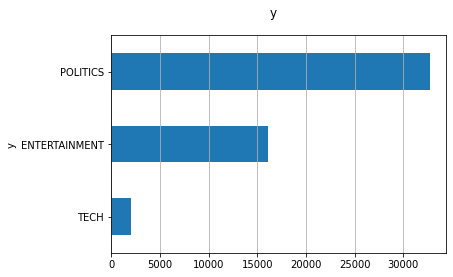

In [14]:
# Check the univariate distribution of the target by showing labels frequency with a bar plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.suptitle('y', fontsize=12)
df['y'].reset_index().groupby('y').count().sort_values(by='index').plot(kind='barh', legend=False, ax=ax).grid(axis='x')
plt.show()

The data is imbalanced.

# Preprocess data
1. Clean data;
2. Remove stop words;
3. Apply lemmatization.

In [23]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Define a function to clean the data

In [24]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
  """
  Proprocessing a string.
  Args:
   text: string - name of column containing text.
   lst_stopwords: list - list of stopwords to remove.
   flg_stemm: bool - whether stemming is to be applied.
   flg_lemm: bool - whether lemmitisation is to be applied.
  return
    cleaned text.
  """
  # Clean (convert to lowercase and remove punctuations and characters and then strip)
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

  # Tokenize (convert from string to list)
  lst_text = text.split()

  # Remove Stopwprds
  if lst_stopwords is not None:
    lst_text = [word for word in lst_text if word not in lst_stopwords]

  # Stemming (remove -ing, -ly, ...)
  if flg_stemm == True:
    ps = nltk.stem.porter.PorterStemmer()
    lst_text = [ps.stem(word) for word in lst_text]

  # Lemmatization (convert the word into root word)
  if flg_lemm == True:
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    lst_text = [lem.lemmatize(word) for word in lst_text]
  
  # Back to string from list
  text = " ".join(lst_text)
  return text

That function removes a set of words from the corpus if given. I can create a list of generic stop words for the English vocabulary with nltk (we could edit this list by adding or removing words).

In [25]:
lst_stopwords = nltk.corpus.stopwords.words('english')
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

## Apply the function to the data
Apply the data cleaning function on the whole data and store the result in a new column named 'text_clean' so that we can choose to work with the raw corpus or the preprocessed text. 


In [26]:
df['text_clean'] = df['text'].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
df.head()

,y,text,text_clean
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,smith join diplo nicky jam 2018 world cup offi...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,hugh grant marries first time age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,jim carrey blast castrato adam schiff democrat...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,julianna margulies us donald trump poop bag pi...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,morgan freeman devastated sexual harassment cl...


In [27]:
df[df['text'] == ''].index

Int64Index([82270], dtype='int64')

## Train Test split

In [28]:
from sklearn import feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics

In [29]:
# Split the dataset
df_train, df_test = model_selection.train_test_split(df, test_size=0.3)

In [167]:
# Gat target
y_train = df_train['y'].values
y_test = df_test['y'].values

# Text Analysis

## Detect the language

In [31]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 27.5 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=e5dadfc46b23cd213af12849d54e620a9cb95e2a6dc2cb0fa8124d4902f8f423
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [32]:
import langdetect

def add_detect_lang(dataframe, text_index):
  # origin_text = dataframe[text_index]
  lang = dataframe[text_index].apply(lambda x: langdetect.detect(x) if x.strip() != "" else "")
  dataframe['lang'] = lang
  return dataframe

In [33]:
add_detect_lang(df, 'text')
df.head()

,y,text,text_clean,lang
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,smith join diplo nicky jam 2018 world cup offi...,en
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,hugh grant marries first time age 57,en
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,jim carrey blast castrato adam schiff democrat...,en
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,julianna margulies us donald trump poop bag pi...,en
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,morgan freeman devastated sexual harassment cl...,en


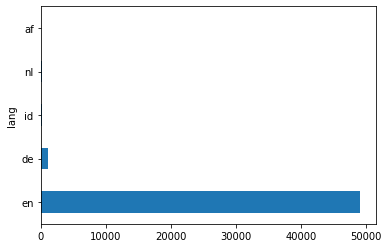

In [34]:
df.groupby('lang').count().sort_values(by='text', ascending=False)[:5]['text'].plot(kind='barh')

In [35]:
# Filter english only
df_eng = df[df['lang'] == 'en']
df_eng

,y,text,text_clean,lang
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,smith join diplo nicky jam 2018 world cup offi...,en
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,hugh grant marries first time age 57,en
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,jim carrey blast castrato adam schiff democrat...,en
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,julianna margulies us donald trump poop bag pi...,en
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,morgan freeman devastated sexual harassment cl...,en
...,...,...,...,...
200843,TECH,Good Games -- Is It possible?,good game possible,en
200844,TECH,Google+ Now Open for Teens With Some Safeguards,google open teen safeguard,en
200846,TECH,"First White House Chief Technology Officer, An...",first white house chief technology officer ane...,en
200847,TECH,Watch The Top 9 YouTube Videos Of The Week,watch top 9 youtube video week,en


# Words treatments

## Bag-of-Words
It builds a vocabulary from a corpus of documents and counts how many times the words appear in each document. To put it another way, each word in the vocabulary becomes a feature and a document is represented by a vector with the same length of the vocabulary (a “bag of words”).

* Significant dimensionality problem (huge sparse matrix);
* The model is usually preceded by data preprocessing (word cleaning, stop words removal, stemming/lemmatization) aim to reduce the dimensionality problem.
* Common words with highest frequency actually contribute little to the target variables.

## Term frequency-inverse document frequency (Tf-Idf)
The value of a word increases proportionally to count, but inversely proportional to the frequency of the word in the corpus.

### Feature Engineering
To ctreate features by extracting information from the data capturing unigrams (i.e. 'new' and 'york') and bigrams (i.e. 'new york').

Count (classic BoW)
vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

In [36]:
# Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

# Apply the vectorizer on the preprocessed corpus to extract a vocabulary and create the feature matrix
corpus = df_train['text_clean']

vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [37]:
X_train.shape

(35615, 10000)

In [38]:
df_train

,y,text,text_clean
40829,TECH,"Google Image, The Daily Stormer And Anti-Semitism",google image daily stormer antisemitism
170891,TECH,You Can Now Download Your Entire Twitter History,download entire twitter history
4294,POLITICS,Trump: Outgoing Economic Adviser Is ‘A Globali...,trump outgoing economic adviser globalist stil...
5095,ENTERTAINMENT,Emily Ratajkowski Marries Sebastian Bear-McCla...,emily ratajkowski marries sebastian bearmcclar...
29402,POLITICS,The School Shooting In San Bernardino Reminds ...,school shooting san bernardino reminds u domes...
...,...,...,...
76916,ENTERTAINMENT,What's New On Netflix For November 2015,whats new netflix november 2015
61612,POLITICS,World Bank May Be Spreading The Scourge That F...,world bank may spreading scourge fed flint wat...
32132,POLITICS,Paul Ryan's Wonk Shtick Is Getting Old,paul ryans wonk shtick getting old
83140,ENTERTAINMENT,Uggie The Dog From 'The Artist' Dead At 13,uggie dog artist dead 13


In [39]:
import seaborn as sns
import numpy as np

Text(0.5, 1.0, 'Sparse Matrix Sample')

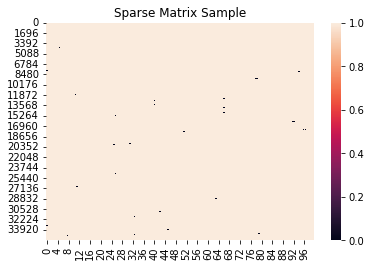

In [40]:
sns.heatmap(X_train.todense()[:, np.random.randint(0, X_train.shape[1], 100)] == 0, vmin=0, vmax=1, cbar=True).set_title('Sparse Matrix Sample')

In [44]:
# Look up a word
word = 'new york'
dic_vocabulary[word]

6028

### Feature Selection
Drop some columns and reduce the matrix dimensionality: select a subset of relevant variabls.

1. Treat each category as binary (reduce the dimensionality of the target);
2. Perform a Chi-square test to determine whether a feature and the binary target are independent;
3. Keep only the features with a certain p_value from the Chi-Square test.

In [45]:
y = df_train['y']
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95

df_features = pd.DataFrame()
for target in np.unique(y):
  chi2, p_value = feature_selection.chi2(X_train, y==target)
  df_features = df_features.append(pd.DataFrame({'Feature': X_names,
                                                 'Score': 1.0-p_value,
                                                 'y': target}))
  df_features = df_features.sort_values(['y', 'Score'], ascending=[True, False])
  df_features = df_features[df_features['Score']>p_value_limit]

X_names = df_features['Feature'].unique().tolist()

In [46]:
len(X_names)

3636

In [47]:
df_features

,Feature,Score,y
229,actor,1.000000,ENTERTAINMENT
346,album,1.000000,ENTERTAINMENT
714,award,1.000000,ENTERTAINMENT
1147,box,1.000000,ENTERTAINMENT
1148,box office,1.000000,ENTERTAINMENT
...,...,...,...
2391,democratic,0.952981,TECH
6471,pay,0.951991,TECH
8131,slash,0.951318,TECH
2018,could save,0.951092,TECH


In [48]:
for target in np.unique(y):
  print(f"{target}")
  print(f" . Selected features: {len(df_features[df_features['y']==target])}")
  print(f" . Top features: {', '.join(df_features[df_features['y']==target]['Feature'].values[:10])}")
  print()

ENTERTAINMENT
 . Selected features: 3058
 . Top features: actor, album, award, box, box office, celebrity, clinton, dead, democrat, donald

POLITICS
 . Selected features: 3030
 . Top features: actor, album, apple, box, box office, clinton, democrat, donald, donald trump, fan

TECH
 . Selected features: 438
 . Top features: amazon, android, app, apple, apple rumor, apps, bug, computer, content, cyber



In [49]:
# Refit the vectorizer to the corpus by giving it our new selected features (not 10000 anymore)
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

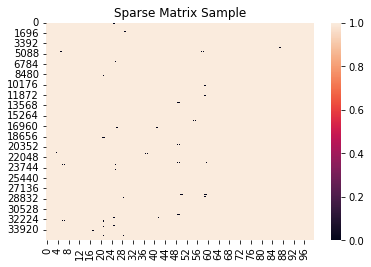

In [50]:
sns.heatmap(X_train.todense()[:, np.random.randint(0, X_train.shape[1], 100)] == 0, vmin=0, vmax=1, cbar=True).set_title('Sparse Matrix Sample')
sns.set(rc={'figure.figsize':(40, 5)})

### Train machine learning model
* Naive Bayes algorithm: a probabilistic classifier that makes use of Bayes' Teroem, a tule that uses probability to make predictions based on prior knowledge of condistions that might be related.

* This model is the mose suitable for such large dataset as it considers each feature independently, calculates the probability of each category, and then predicts the category with the highest probability.

In [51]:
classifier = naive_bayes.MultinomialNB()

### Build a scikit-learn pepeline

A sequential application of a list of transformations and a final estimator.

Putting the Tf-Idf vectorizer and the Naive Bayes classifier in a pipeline allows us to transform and predict test data in just one step.

In [52]:
model = pipeline.Pipeline([('vectorizer', vectorizer),
                           ('classifier', classifier)])

### Train the classifier (model)

In [53]:
model['classifier'].fit(X_train, y_train)

MultinomialNB()

### Test the classifier


In [54]:
X_test = df_test['text_clean'].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

### Evaluate the performance
There are several metrics:
1. Accuracy: the fraction of predictions the model got right.
2. Confusion Matrix: a summary table that breaks down the number of correct and incorrect predictions by each class.
3. ROC: a plot that illustrates the true positive rate against the false positive rate at various threshold settings. The area under the curve (AUC) indicates the probability that the classifier will rank a randomly chosen positive observation higher than a randomly chosen negative one.
4. Precision: the fraction of relevant instances among the retrieved instances.
5. Recall: the fraction of the total amount of relevant instances that were actually retrieved.

In [55]:
classes = np.unique(y_test)
classes

array(['ENTERTAINMENT', 'POLITICS', 'TECH'], dtype=object)

In [56]:
y_test

array(['ENTERTAINMENT', 'ENTERTAINMENT', 'POLITICS', ..., 'POLITICS',
       'POLITICS', 'ENTERTAINMENT'], dtype=object)

In [57]:
y_test_array = pd.get_dummies(y_test, drop_first=False).values
y_test_array

array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]], dtype=uint8)

Accuracy, Precision, Recall

The BoW model got 91% accuracy, but struggles to recogonize Tech news (only 204 predicted correctly).

In [58]:
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class='ovr')
print(f"Accuracy: {round(accuracy, 2)}")
print(f"Auc: {round(auc, 2)}")
print(f"Details:\n {metrics.classification_report(y_test, predicted)}")

Accuracy: 0.92
Auc: 0.97
Details:
                precision    recall  f1-score   support

ENTERTAINMENT       0.91      0.89      0.90      4779
     POLITICS       0.92      0.97      0.94      9877
         TECH       0.92      0.29      0.44       608

     accuracy                           0.92     15264
    macro avg       0.92      0.72      0.76     15264
 weighted avg       0.92      0.92      0.91     15264



Plot confusion matrix

(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

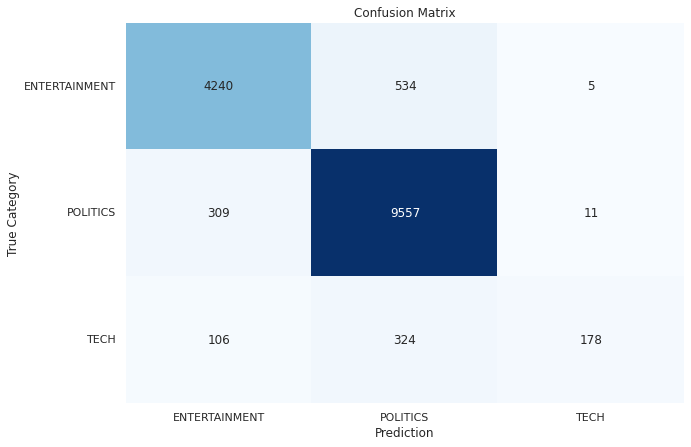

In [59]:
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Prediction', ylabel='True Category', xticklabels=classes, yticklabels=classes, title='Confusion Matrix')

plt.yticks(rotation=0)

Plot roc/precision-recall curve

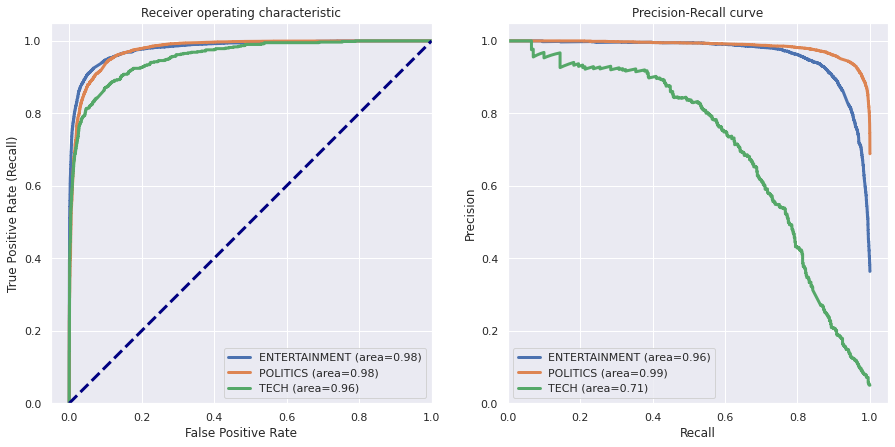

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

# Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### Explain the model's prediction
Let's understand why the model calssifies news within a certain category and assess the explainability of these predictions.

The lime (Local Interpretable Model-Agnostic Explanations) package can help us to build an explainer.

In [64]:
y_test

array(['ENTERTAINMENT', 'ENTERTAINMENT', 'POLITICS', ..., 'POLITICS',
       'POLITICS', 'ENTERTAINMENT'], dtype=object)

In [65]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 28.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=10f44155f9b73372f29483502628deb5614209c9f7680eb39881874ee26b56b4
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [66]:
from lime.lime_text import LimeTextExplainer

In [67]:
# Select a random observation
i = 36
txt_instance = df_test['text'].iloc[i]

# Check the value and predicted value
print(f"True value: {y_test[i]} ---> Pred: {predicted[i]} | Prob: {round(np.max(predicted_prob[i]),3)}")

True value: POLITICS ---> Pred: POLITICS | Prob: 0.878


In [68]:
# Show explanation
explainer = LimeTextExplainer(class_names=np.unique(y_train))
explained = explainer.explain_instance(txt_instance, model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

## Wording Embedding


### Word2Vec
* It produces a vector space, typically of several hundred dimensions, with each unique word in the corous such that words that share common contexts in the corpus are located close to on another in the space.

* It can be done using 2 different approches: 
 1. Starting from a single word to predict its context (Skip-gram);
 2. Starting from the context to predict a word (Continuous Bag-of-Words). 

#### Load a pre-trained WordEmbedding model from Genism-data

In [69]:
import gensim.downloader as gensim_api
import gensim

In [70]:
nlp = gensim_api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


#### Detect n-grams list

* Before fitting the model, the corpus needs to be transformed into a list of lists of n-grams. For example: unigrams ('york'), bigrams ('new york'), and trigrams ('new york city').

In [71]:
corpus_train = df_train['text_clean']
corpus_train

40829               google image daily stormer antisemitism
170891                      download entire twitter history
4294      trump outgoing economic adviser globalist stil...
5095      emily ratajkowski marries sebastian bearmcclar...
29402     school shooting san bernardino reminds u domes...
                                ...                        
76916                       whats new netflix november 2015
61612     world bank may spreading scourge fed flint wat...
32132                    paul ryans wonk shtick getting old
83140                              uggie dog artist dead 13
146444    lady gaga miley cyrus vma reaction people need...
Name: text_clean, Length: 35615, dtype: object

In [72]:
# create list of lists of unigrams
lst_corpus_train = []
for string in corpus_train:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
   lst_corpus_train.append(lst_grams)

# detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus_train, delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)

trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus_train], delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

lst_corpus_train = bigrams_detector[lst_corpus_train]
lst_corpus_train = trigrams_detector[lst_corpus_train]

#### Fit the Word2Vec

Instead of using the google pretrained model, I'll train my own word embedding vectors.

Fit the Word2Vec to the corpus, there are things to specify:
1. The target size of the word vectors (i.e. 300);
2. The window, or the maximum distance between the current and predicted word with a sentence, here we use the mean length of text in the corpus;
3. The training algorithm: skip-grams (sg=1) as in general it has better results.

In [73]:
# From the train corpus generating word embeddings
nlp = gensim.models.word2vec.Word2Vec(lst_corpus_train, size=300, window=8, min_count=1, sg=1, iter=30)

We now have our own embedding model, we can select amy word from the corpus and transform it into a vector.

In [74]:
word = 'data'
nlp[word].shape

(300,)

#### Visualize the word embedding
We can use it to visualise a word and its context into a smaller dimensional space (2D or 3D) by applying and dimensionality reduction algorithm (i.e. TSNE)

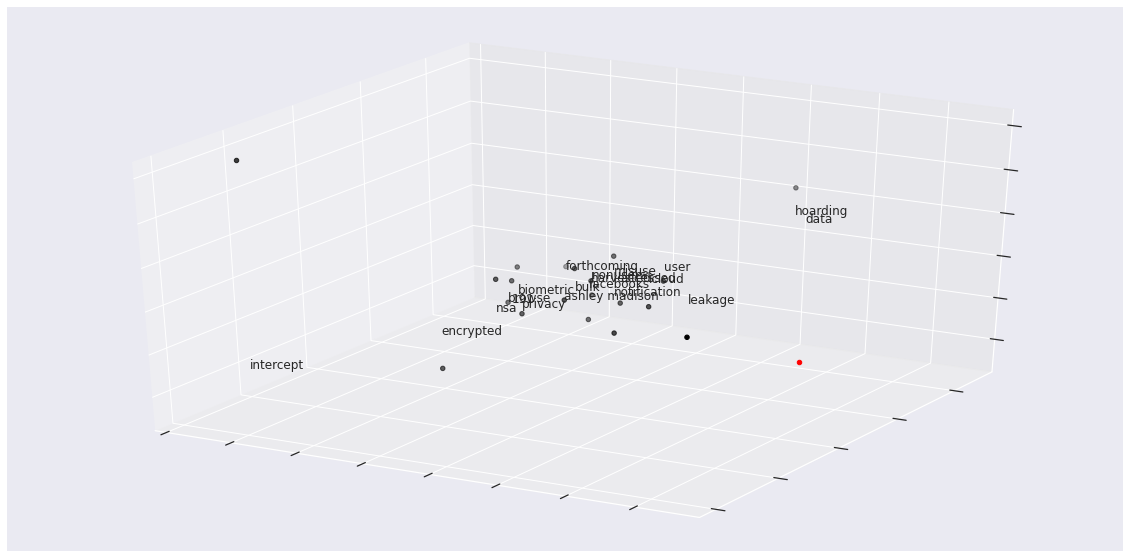

In [76]:
word = 'data'
fig = plt.figure(figsize=(20, 10))

# Word Embedding
total_words = [word] + [freq_list[0] for freq_list in nlp.most_similar(word, topn=20)]
X = nlp[total_words]

# Perform PCA to reduce dimensionality from 300 to 3
pca = manifold.TSNE(n_components=3, perplexity=40, init='pca')
X = pca.fit_transform(X)

# Create dataframe
df_ = pd.DataFrame(X, index=total_words, columns=['x', 'y', 'z'])
df_['input'] = 0
df_['input'].iloc[0:1] = 1

# Plot 3D graph
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_[df_['input']==0]['x'],
           df_[df_['input']==0]['y'],
           df_[df_['input']==0]['z'], c='black')

ax.scatter(df_[df_['input']==1]['x'],
           df_[df_['input']==1]['y'],
           df_[df_['input']==1]['z'], c='red')

ax.set(xlabel=None, ylabel=None, zlabel=None,
       xticklabels=[], yticklabels=[], zticklabels=[])

for label, row in df_[['x', 'y', 'z']].iterrows():
  x, y, z = row
  ax.text(x, y, x, s=label)

In [77]:
import plotly.express as px

for label, row in df_[['x', 'y', 'z']].iterrows():
  x, y, z = row
  s=label

fig = px.scatter_3d(df_, x='x', y='y', z='z', color='input', symbol=df_.index)
fig.show()

The word vectors can be used in a neural netword as weights:

1. Transform the corpus into padded sequences of word ids to get a feature matrix;
2. Create an embedding matrix so that the vector of the word with id N is located at the Nth row.
3. Build a neural network with an embedding layer that weights every word in the sequences with the corresponding vector.

#### Build sequence matrix

In [78]:
len(lst_corpus_train)

35615

In [79]:
import tensorflow as tf
from tensorflow.keras import preprocessing, layers, models, optimizers

In [80]:
# Tokenize text
tokenizer = preprocessing.text.Tokenizer(lower=True,
                                         split=' ', 
                                         oov_token="NaN", 
                                         filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus_train)
dic_vocabulary = tokenizer.word_index

# Create a sequence
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus_train)

# Padding sequence
X_train = preprocessing.sequence.pad_sequences(lst_text2seq,
                                               maxlen=15,
                                               padding='post',
                                               truncating='post')

In [81]:
X_train

array([[  202,  1548,  2275, ...,     0,     0,     0],
       [10783,  1989,    64, ...,     0,     0,     0],
       [    2, 10784,   553, ...,     0,     0,     0],
       ...,
       [ 1234, 24093, 24094, ...,     0,     0,     0],
       [24095,   583,   733, ...,     0,     0,     0],
       [  929,   552,  5272, ...,     0,     0,     0]], dtype=int32)

The feature matrix X_train has a shape of 35615 * 15 (Number of sequences * Max-length of sequences).

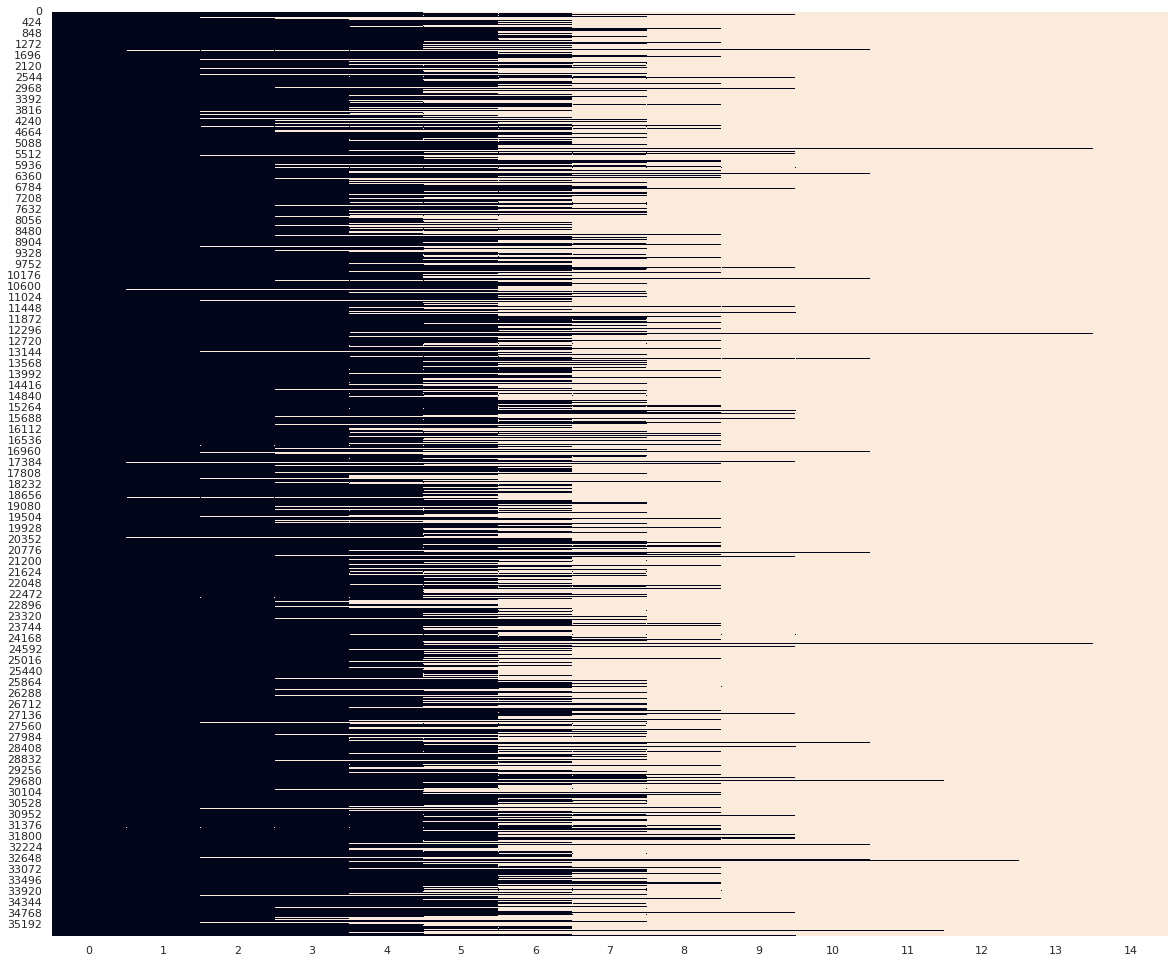

In [82]:
# Visualize the matrix
plt.figure(figsize=(20, 17))
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

Every text in the corpus is now an id sequence with length 15. For instance, if a text had 10 tokens in it, then the sequence is composed of 10 ids + 5 0s, which is the padding element (while the id for word not in the vocabulary is 1). 


In [83]:
# Print how a text is transfromed
i = 0

# A list of text
len_txt = len(df_train['text_clean'].iloc[i].split())
print(f"From: {df_train['text_clean'].iloc[i]} | len: {len_txt}")

# A sequence of token ids
len_tokens = len(X_train[i])
print(f"to {X_train[i]} | len: {len_tokens}")

# Vocabulary
print(f"Check: {df_train['text_clean'].iloc[i].split()[0]} -- idx in vocabulary -- {dic_vocabulary[df_train['text_clean'].iloc[i].split()[0]]}")

print(f"Vocabulary: {dict(list(dic_vocabulary.items())[:5])}")

From: google image daily stormer antisemitism | len: 5
to [ 202 1548 2275 9045 2827    0    0    0    0    0    0    0    0    0
    0] | len: 15
Check: google -- idx in vocabulary -- 202
Vocabulary: {'NaN': 1, 'trump': 2, 'donald trump': 3, 'say': 4, 'new': 5}


In [85]:
corpus_test = df_test['text_clean']

# create list of n-grams
lst_corpus_test = []
for string in corpus_test:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus_test.append(lst_grams)
    
# detect common bigrams and trigrams using the fitted detectors
lst_corpus_test = list(bigrams_detector[lst_corpus_test])
lst_corpus_test = list(trigrams_detector[lst_corpus_test])
# text to sequence with the fitted tokenizer
lst_text2seq_test = tokenizer.texts_to_sequences(lst_corpus_test)

# padding sequence
X_test = preprocessing.sequence.pad_sequences(lst_text2seq_test, maxlen=15, padding="post", truncating="post")

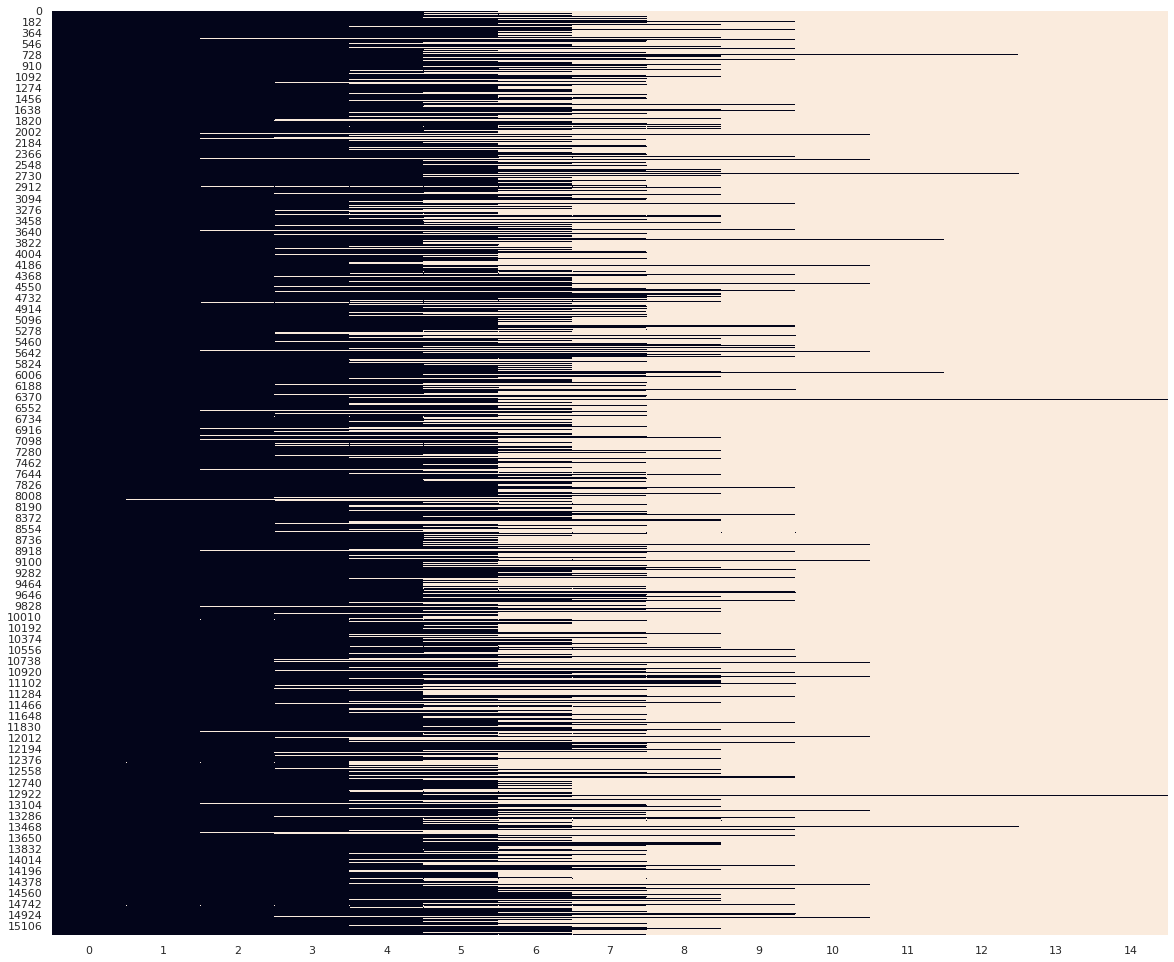

In [86]:
# Visualize the matrix
plt.figure(figsize=(20, 17))
sns.heatmap(X_test==0, vmin=0, vmax=1, cbar=False)
plt.show()

#### Build weight matrix

In [87]:
nlp

In [88]:
# Start the word embedding matrix (length of vocabulary * length of single word vector) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))

for word, idx in dic_vocabulary.items():
  # Updata the row with nlp vector
  try:
    embeddings[idx] = nlp[word]
  # If a word is not in the model, skip and row stays in 0s
  except:
    pass

In [89]:
embeddings.shape

(24097, 300)

In [90]:
word = 'data'
print(f"Word: {word}, index: {dic_vocabulary[word]}")
print(f"Embedding: {embeddings[dic_vocabulary[word]].shape}")

Word: data, index: 565
Embedding: (300,)


#### Build a deep learning model
The neural netword will be structured as:
1. An embedding layer that takes the sequences as input and the word vectors as weights, just as described before.
2. A simple attention layer that won’t affect the predictions but it’s going to capture the weights of each instance and allow us to build a nice explainer (it isn't necessary for the predictions, just for the explainability, so you can skip it). The Attention mechanism was presented in [this paper](https://https://arxiv.org/abs/1409.0473) (2014) as a solution to the problem of the sequence models (i.e. LSTM) to understand what parts of a long text are actually relevant.
3. Two layers of Bidirectional LSTM to model the order of words in a sequence in both directions.
4. Two final dense layers that will predict the probability of each news category.

In [91]:
# Define the attention layer
def attention_layer(inputs, neurons):
  x = layers.Permute((2, 1))(inputs)
  x = layers.Dense(neurons, activation='softmax')(x)
  x = layers.Permute((2, 1), name='attention')(x)
  x = layers.multiply([inputs, x])
  return x

# Input data
x_in = layers.Input(shape=(15,))

# Embedding
x = layers.Embedding(input_dim=embeddings.shape[0],
                     output_dim=embeddings.shape[1],
                     weights=[embeddings],
                     input_length=15,
                     trainable=False)(x_in)

# Apply attention layer
x = attention_layer(x, neurons=15)

# 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)

# Final dense layer
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)

# Compile the model
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 300)      7229100     ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 300, 15)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 300, 15)      240         ['permute[0][0]']                
                                                                                              

#### Train the model

In [92]:
y_train = df_train['y'].values
y_train

array(['TECH', 'TECH', 'POLITICS', ..., 'POLITICS', 'ENTERTAINMENT',
       'ENTERTAINMENT'], dtype=object)

In [182]:
dic_y_mapping = {n:label for n, label in enumerate(y_train)}
dic_y_mapping

{0: 'TECH',
 1: 'TECH',
 2: 'POLITICS',
 3: 'ENTERTAINMENT',
 4: 'POLITICS',
 5: 'POLITICS',
 6: 'POLITICS',
 7: 'POLITICS',
 8: 'ENTERTAINMENT',
 9: 'POLITICS',
 10: 'POLITICS',
 11: 'POLITICS',
 12: 'ENTERTAINMENT',
 13: 'ENTERTAINMENT',
 14: 'TECH',
 15: 'POLITICS',
 16: 'POLITICS',
 17: 'ENTERTAINMENT',
 18: 'ENTERTAINMENT',
 19: 'POLITICS',
 20: 'ENTERTAINMENT',
 21: 'ENTERTAINMENT',
 22: 'ENTERTAINMENT',
 23: 'ENTERTAINMENT',
 24: 'POLITICS',
 25: 'POLITICS',
 26: 'TECH',
 27: 'POLITICS',
 28: 'POLITICS',
 29: 'POLITICS',
 30: 'ENTERTAINMENT',
 31: 'ENTERTAINMENT',
 32: 'ENTERTAINMENT',
 33: 'POLITICS',
 34: 'POLITICS',
 35: 'POLITICS',
 36: 'ENTERTAINMENT',
 37: 'POLITICS',
 38: 'POLITICS',
 39: 'POLITICS',
 40: 'ENTERTAINMENT',
 41: 'POLITICS',
 42: 'POLITICS',
 43: 'POLITICS',
 44: 'TECH',
 45: 'POLITICS',
 46: 'POLITICS',
 47: 'POLITICS',
 48: 'ENTERTAINMENT',
 49: 'POLITICS',
 50: 'TECH',
 51: 'POLITICS',
 52: 'ENTERTAINMENT',
 53: 'ENTERTAINMENT',
 54: 'TECH',
 55: 'POLITIC

In [171]:
# Encode y
dic_y_mapping = {n:label for n, label in enumerate(np.unique(y_train))}
dic_y_mapping

{0: 'ENTERTAINMENT', 1: 'POLITICS', 2: 'TECH'}

In [172]:
inverse_dic = {v:k for k, v in dic_y_mapping.items()}
inverse_dic

{'ENTERTAINMENT': 0, 'POLITICS': 1, 'TECH': 2}

In [96]:
y_train = np.array([inverse_dic[y] for y in y_train])
y_train

array([2, 2, 1, ..., 1, 0, 0])

In [97]:
# Train the model
history = model.fit(x=X_train,
                   y=y_train,
                   batch_size=32,
                   epochs=15,
                   validation_split=0.3)

Epoch 1/15
780/780 [==============================] - 24s 15ms/step - loss: 0.3539 - accuracy: 0.8698 - val_loss: 0.2533 - val_accuracy: 0.9117
Epoch 2/15
780/780 [==============================] - 11s 14ms/step - loss: 0.2508 - accuracy: 0.9127 - val_loss: 0.2344 - val_accuracy: 0.9176
Epoch 3/15
780/780 [==============================] - 10s 13ms/step - loss: 0.2396 - accuracy: 0.9165 - val_loss: 0.2328 - val_accuracy: 0.9179
Epoch 4/15
780/780 [==============================] - 11s 13ms/step - loss: 0.2319 - accuracy: 0.9193 - val_loss: 0.2297 - val_accuracy: 0.9170
Epoch 5/15
780/780 [==============================] - 11s 14ms/step - loss: 0.2243 - accuracy: 0.9217 - val_loss: 0.2238 - val_accuracy: 0.9212
Epoch 6/15
780/780 [==============================] - 10s 13ms/step - loss: 0.2182 - accuracy: 0.9229 - val_loss: 0.2251 - val_accuracy: 0.9199
Epoch 7/15
780/780 [==============================] - 10s 13ms/step - loss: 0.2129 - accuracy: 0.9229 - val_loss: 0.2167 - val_accuracy:

In [98]:
metrics = [k for k in history.history.keys() if ("loss" not in k) and ("val" not in k)]
metrics

['accuracy']

In [99]:
history.history

{'loss': [0.3538709878921509,
  0.250777930021286,
  0.2395917922258377,
  0.23188462853431702,
  0.2242622673511505,
  0.21815991401672363,
  0.21289654076099396,
  0.2086862325668335,
  0.20246174931526184,
  0.19764699041843414,
  0.19343975186347961,
  0.18926233053207397,
  0.18654339015483856,
  0.18283654749393463,
  0.18088404834270477],
 'accuracy': [0.8697553277015686,
  0.9127156138420105,
  0.9165262579917908,
  0.919293999671936,
  0.9216606616973877,
  0.9228640198707581,
  0.9229041337966919,
  0.9272763729095459,
  0.929522693157196,
  0.9310870170593262,
  0.9315683841705322,
  0.9340152144432068,
  0.9337344765663147,
  0.9353389739990234,
  0.9351785182952881],
 'val_loss': [0.25333893299102783,
  0.2344202697277069,
  0.23279277980327606,
  0.2297080010175705,
  0.22378048300743103,
  0.22508755326271057,
  0.21668310463428497,
  0.2184901237487793,
  0.20975124835968018,
  0.21570904552936554,
  0.20599792897701263,
  0.20630280673503876,
  0.2088468074798584,
  0.

Text(0, 0.5, 'Val_accuracy')

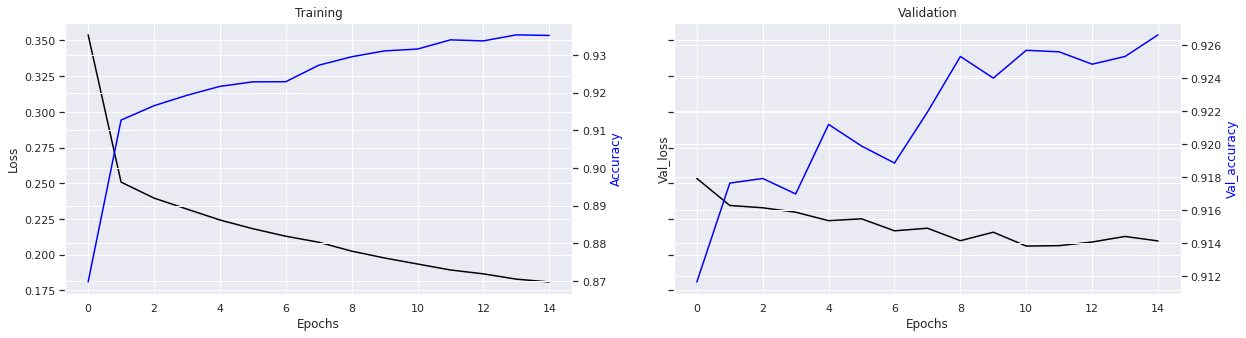

In [100]:
# Plot loss and accuracy curves
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20, 5))
ax[0].set(title='Training')
ax11 = ax[0].twinx()
ax[0].plot(history.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax11.plot(history.history['accuracy'], color='blue')
ax11.set_ylabel('Accuracy', color='blue')

ax[1].set(title='Validation')
ax22 = ax[1].twinx()
ax[1].plot(history.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Val_loss')
ax22.plot(history.history['val_accuracy'], color='blue')
ax22.set_ylabel('Val_accuracy', color='blue')

#### Predict on the test data

In [101]:
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]

In [102]:
predicted = np.array(predicted)
predicted.shape, type(predicted)

((15264,), numpy.ndarray)

#### Evaluate the performance

In [103]:
y_test = df_test['y'].values
y_test.shape, type(y_test)

((15264,), numpy.ndarray)

Accuracy: 0.93
Auc: 0.98
Details:
                precision    recall  f1-score   support

ENTERTAINMENT       0.91      0.91      0.91      4779
     POLITICS       0.94      0.96      0.95      9877
         TECH       0.81      0.55      0.66       608

     accuracy                           0.93     15264
    macro avg       0.89      0.81      0.84     15264
 weighted avg       0.93      0.93      0.93     15264



(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

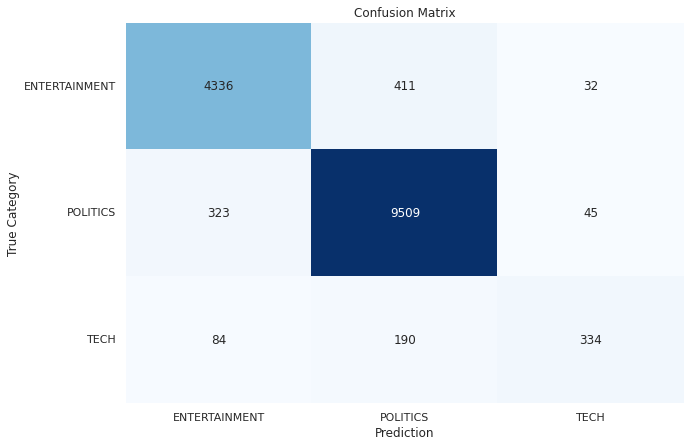

In [104]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report

accuracy = accuracy_score(y_test, predicted)
auc = roc_auc_score(y_test, predicted_prob, multi_class='ovr')
print(f"Accuracy: {round(accuracy, 2)}")
print(f"Auc: {round(auc, 2)}")
print(f"Details:\n {classification_report(y_test, predicted)}")

confusion_matrix = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Prediction', ylabel='True Category', xticklabels=classes, yticklabels=classes, title='Confusion Matrix')

plt.yticks(rotation=0)

In [105]:
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, auc

In [106]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
y_test_array

array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]], dtype=uint8)

In [107]:
predicted_prob

array([[9.25811946e-01, 6.12674244e-02, 1.29205445e-02],
       [1.15101941e-01, 8.82433414e-01, 2.46460014e-03],
       [1.57087389e-03, 9.98009861e-01, 4.19314281e-04],
       ...,
       [5.04853344e-03, 9.94571388e-01, 3.80088051e-04],
       [8.01095157e-05, 9.99536276e-01, 3.83682956e-04],
       [9.98956680e-01, 8.51923600e-04, 1.91414903e-04]], dtype=float32)

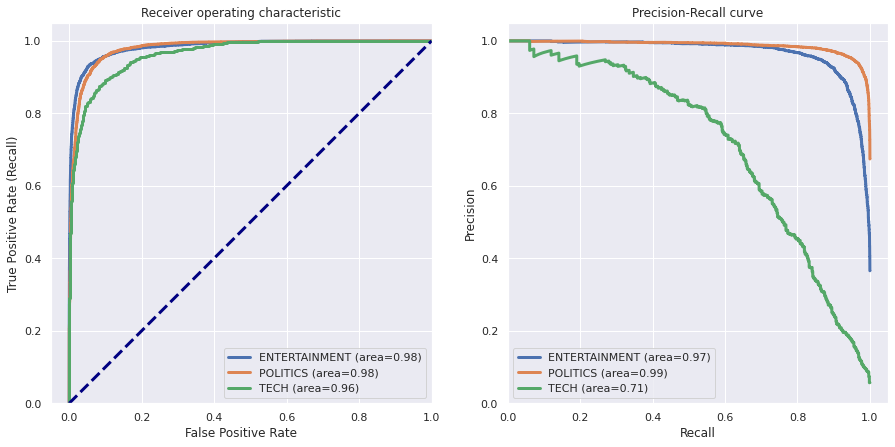

In [109]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i], predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], auc(fpr, tpr)))
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0],
          ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], auc(recall, precision)))
ax[1].set(xlim=[0.0,1.05],
          ylim=[0.0,1.05],
          xlabel='Recall', 
          ylabel="Precision",
          title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

#### Explain the model's prediction

We have put an Addition layer in the neural network to extract the weights of each word and understand how much those contributed to classify an instance.

We will use the Attention weights to build an explainer.

In [110]:
# Select an observation
i = 0
txt_instance = df_test['text_clean'].iloc[i]

# Check true value and predicted value
print(f"True value: {y_test[i]} --> Predicted value: {predicted[i]}, Prob: {round(np.argmax(predicted[i]))}")

True value: ENTERTAINMENT --> Predicted value: ENTERTAINMENT, Prob: 0


In [111]:
txt_instance

'antman slip past pixel win weekend'

In [112]:
model.layers

In [113]:
model.layers[0].name

'input_1'

In [114]:
from keras import backend as K
import sklearn

In [115]:
for string in [re.sub(r'[^\w\s]', '', txt_instance.lower().strip())]:
  exp_lst_words = string.split()
  exp_lst_unigrams = [' '.join(exp_lst_words[n]) for n in range(len(exp_lst_words))]

In [116]:
exp_lst_words

['antman', 'slip', 'past', 'pixel', 'win', 'weekend']

In [ ]:
exp_lst_unigrams

In [117]:
# The explaination
# 1. Preprocess input
exp_lst_corpus = []
# Get the list of unigrams
for string in [re.sub(r'[^\w\s]', '', txt_instance.lower().strip())]:
  exp_lst_words = string.split()
  exp_lst_unigrams = [''.join(exp_lst_words[n]) for n in range(len(exp_lst_words))]
  exp_lst_corpus.append(exp_lst_unigrams)

# Prepare the unigrams into bigrams and trigrams
exp_lst_corpus = list(bigrams_detector[exp_lst_corpus])
exp_lst_corpus = list(trigrams_detector[exp_lst_corpus])

# Prepare the text into padded sequence
X_instance = preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(lst_corpus_test), # Transforms each text in texts to a sequence of integers.
                                                  maxlen=15,
                                                  dtype='int32',
                                                  padding='post',
                                                  truncating='post')
tokenizer.fit_on_texts(lst_corpus_test)
exp_dic_vocabulary = tokenizer.word_index

# 2. Get attention weights
layer = [layer for layer in model.layers if 'attention' in layer.name][0]
func = K.function([model.input], [layer.output])
weights = func(X_instance)[0]
weights = np.mean(weights, axis=2).flatten()

# 3. Rescale weights
weights = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1)).fit_transform(np.array(weights).reshape(-1, 1)).reshape(-1)
# Remove null vector
weights = [weights[n] for n, idx in enumerate(X_instance[0]) if idx != 0]
# Map word-weight
dic_word_weight = {word: weights[n] for n,word in enumerate(exp_lst_corpus[0]) if word in exp_dic_vocabulary.keys()}

In [118]:
weights

[0.94381076, 0.43057036, 0.36694735, 0.32191256, 0.31028077]

In [119]:
dic_word_weight

{'antman': 0.94381076,
 'slip': 0.43057036,
 'past': 0.36694735,
 'pixel': 0.32191256,
 'win weekend': 0.31028077}

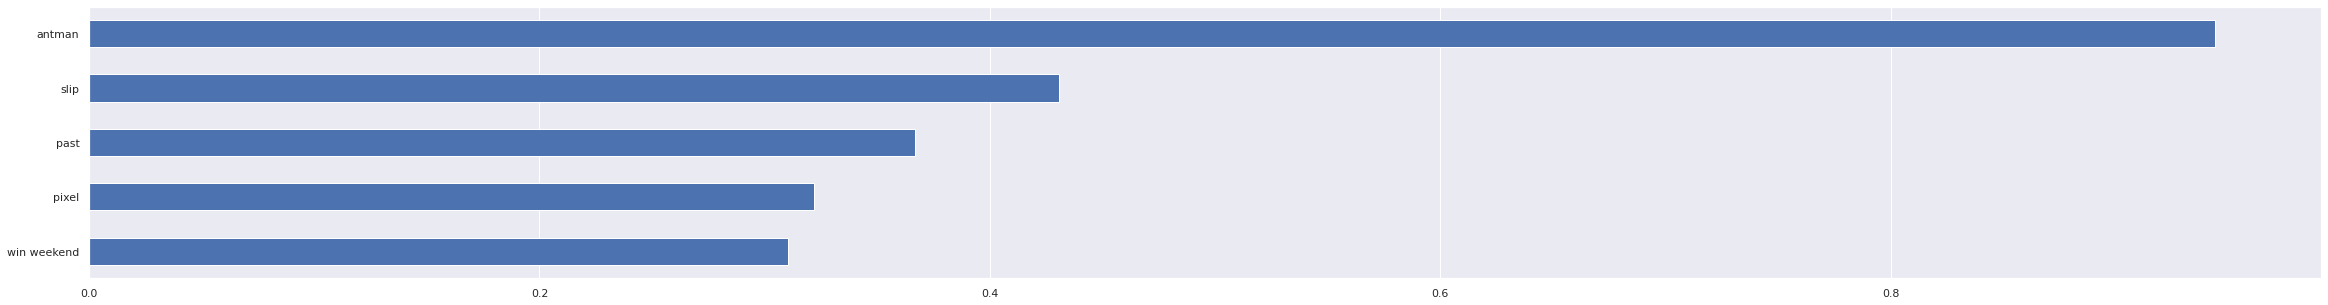

In [120]:
# 4. Plot barplot
if len(dic_word_weight) > 0:
  dfw = pd.DataFrame.from_dict(dic_word_weight, orient='index', columns=['Score'])
  dfw.sort_values(by='Score', ascending=True).plot(kind='barh', legend=False).grid(axis='y')
else:
  print('No word recognized.')

In [121]:
dfw

,Score
antman,0.943811
slip,0.430570
past,0.366947
pixel,0.321913
win weekend,0.310281


In [122]:
# 5. produce html visualization
text = []
for word in exp_lst_corpus[0]:
    weight = dic_word_weight.get(word)
    if weight is not None:
         text.append('<b><span style="background-color:rgba(100,149,237,' + str(weight) + ');">' + word + '</span></b>')
    else:
         text.append(word)
text = ' '.join(text)

# 6. visualize on notebook
print("\033[1m"+"Text with highlighted words")
from IPython.core.display import display, HTML
display(HTML(text))

Text with highlighted words


### Dynamic embedding (BERT)
1. Language Models, or Contextualized/Dynamic Word Embeddings: overcome the problem of polysemy, --> ELMO.
2. Enter Transformers
3. Google's BERT (Bidirectional Encoder Presentations from Transformers) combines ELMO context embedding and several Transformers.

#### Bert application example

In [123]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 27.4 MB/s 
     |████████████████████████████████| 6.6 MB 65.4 MB/s 
     |████████████████████████████████| 120 kB 4.7 MB/s 


In [124]:
import transformers
import numpy as np

In [125]:
txt = 'bank river'

# Bert tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Bert model
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')

# Return hidden layer with embeddings
input_ids = np.array(tokenizer.encode(txt))[None,:]
embedding = nlp(input_ids)
embedding

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 4, 768), dtype=float32, numpy=
array([[[-0.34245968,  0.05200436, -0.2565389 , ..., -0.24441774,
          0.05279814,  0.44900668],
        [-0.38362497, -0.66715163, -0.35021335, ..., -0.10210493,
         -0.21629445, -0.29299957],
        [-0.3499616 , -0.08317098, -0.98768336, ...,  0.06963326,
         -0.49453   , -0.1608825 ],
        [ 0.7392344 ,  0.07391967, -0.45680934, ..., -0.0241577 ,
         -0.7649662 , -0.28110713]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-8.56180251e-01, -3.10129732e-01, -3.13839972e-01,
         7.29850650e-01,  1.41912282e-01, -9.09009278e-02,
         8.59852552e-01,  2.23355159e-01, -2.15244025e-01,
        -9.99963343e-01, -1.96205303e-01,  6.77614570e-01,
         9.75686550e-01,  5.22444434e-02,  8.93248975e-01,
        -6.07509315e-01, -2.02325046e-01, -5.57126641e-01,
         4.13295627e-01, -6.62268817e

In [126]:
embedding[0][0]

<tf.Tensor: shape=(4, 768), dtype=float32, numpy=
array([[-0.34245968,  0.05200436, -0.2565389 , ..., -0.24441774,
         0.05279814,  0.44900668],
       [-0.38362497, -0.66715163, -0.35021335, ..., -0.10210493,
        -0.21629445, -0.29299957],
       [-0.3499616 , -0.08317098, -0.98768336, ...,  0.06963326,
        -0.49453   , -0.1608825 ],
       [ 0.7392344 ,  0.07391967, -0.45680934, ..., -0.0241577 ,
        -0.7649662 , -0.28110713]], dtype=float32)>

#### Bert in text calssification task

There are 3 ways to use BERT:
1. Train it all from scratches and use it at calssifier.
2. Extract the word embeddings and use them in an embedding layer (like in Word2Vec).
3. Fine-tuning the pretrained model (transfer learning).

I will go with the latter and do transfer learning from a pre-trained lighter version of BERT, called [Distill_BERT](https://https://huggingface.co/docs/transformers/model_doc/distilbert) (66 million of parameters instead of 110 milliom).

#### Tokenize the words

In [127]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [128]:
import transformers
import numpy as np

In [129]:
# Distill-bert tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

In [130]:
df_train = df_train.dropna()
corpus = df_train['text_clean']
maxlen = 50

# Add special tokens
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ['[CLS] ' + ' '.join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', str(txt).lower().strip()))[:maxqnans]) + ' [SEP]' for txt in corpus]

# Genarate masks
masks = [[1]*len(txt.split(' ')) + [0]*(maxlen - len(txt.split(' '))) for txt in corpus_tokenized]

# Padding
txt2seq = [txt + ' [PAD]'*(maxlen-len(txt.split(' '))) if len(txt.split(' ')) != maxlen else txt for txt in corpus_tokenized]

# Generate idx
idx = [tokenizer.convert_tokens_to_ids(seq.split(' ')) for seq in txt2seq]

# Generate segments
segments = []
for seq in txt2seq:
  seg, i = [], 0
  for token in seq.split(' '):
    seg.append(i)
    if token == '[SEP]':
      i += 1
  segments.append(seg)

# Feature matrix
X_train = [np.asarray(idx, dtype='int32'),
           np.asarray(masks, dtype='int32'),
           np.asarray(segments, dtype='int32')]

In [132]:
X_train[:2]

[array([[  101,  8224,  3746, ...,     0,     0,     0],
        [  101,  8816,  2972, ...,     0,     0,     0],
        [  101,  8398, 22011, ...,     0,     0,     0],
        ...,
        [  101,  2703,  4575, ...,     0,     0,     0],
        [  101,  1057, 13871, ...,     0,     0,     0],
        [  101,  3203, 23332, ...,     0,     0,     0]], dtype=int32),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)]

In [133]:
corpus.iloc[0]

'google image daily stormer antisemitism'

In [134]:
corpus_tokenized[0]

'[CLS] google image daily storm ##er anti ##se ##mit ##ism [SEP]'

In [178]:
print(masks[0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [136]:
txt2seq[0]

'[CLS] google image daily storm ##er anti ##se ##mit ##ism [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [179]:
print(idx[0])

[101, 14405, 2386, 7540, 2627, 22138, 2663, 5353, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [180]:
print(segments[0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


#### Build transfer learning model

In [139]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [140]:
# Inputs
idx = layers.Input((50), dtype='int32', name='input_idx')
masks = layers.Input((50), dtype='int32', name='input_masks')
segments = layers.Input((50), dtype='int32', name='input_segments')

# Pretrained bert
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False

nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
bert_out = nlp(idx, attention_mask=masks)[0] # output raw hidden-states without any specific head on top.

# Fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out)
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)

# Compile
model = models.Model([idx, masks], y_out)

for layer in model.layers[:3]:
  layer.trainable = False

model.compile(loss='sparse_categorical_crossentropy', # 与y_train的label格式有关
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 50)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 50)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_idx[0][0]',              
 BertModel)                     ast_hidden_state=(N               'input_masks[0][0]']            
                                one, 50, 768),                                                    
                                 hidden_states=None                                         

#### Train, test, evaluate

In [141]:
y_train

array([2, 2, 1, ..., 1, 0, 0])

In [142]:
# Encode for y
dic_y_mapping = {index_class: str_class for index_class, str_class in enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

In [143]:
# Train
history = model.fit(x=X_train[:2],
                   y=y_train,
                   batch_size=64,
                   epochs=1,
                   shuffle=True,
                   validation_split=0.3)

390/390 [==============================] - 74s 172ms/step - loss: 0.3126 - accuracy: 0.8854 - val_loss: 0.2538 - val_accuracy: 0.9086


In [144]:
df_test = df_test.dropna()
corpus = df_test['text_clean']
maxlen = 50

# Add special tokens
maxqnans = np.int((maxlen-20)/2)
corpus_tokenized = ['[CLS] ' + ' '.join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', str(txt).lower().strip()))[:maxqnans]) + ' [SEP]' for txt in corpus]

# Genarate masks
masks = [[1]*len(txt.split(' ')) + [0]*(maxlen - len(txt.split(' '))) for txt in corpus_tokenized]

# Padding
txt2seq = [txt + ' [PAD]'*(maxlen-len(txt.split(' '))) if len(txt.split(' ')) != maxlen else txt for txt in corpus_tokenized]

# Generate idx
idx = [tokenizer.convert_tokens_to_ids(seq.split(' ')) for seq in txt2seq]

# Generate segments
segments = []
for seq in txt2seq:
  seg, i = [], 0
  for token in seq.split(' '):
    seg.append(i)
    if token == '[SEP]':
      i += 1
  segments.append(seg)

# Feature matrix
X_test = [np.asarray(idx, dtype='int32'),
           np.asarray(masks, dtype='int32'),
           np.asarray(segments, dtype='int32')]

In [145]:
X_test = X_test[:2]
X_test

[array([[  101, 14405,  2386, ...,     0,     0,     0],
        [  101, 16392, 10798, ...,     0,     0,     0],
        [  101, 21301, 19894, ...,     0,     0,     0],
        ...,
        [  101,  5969,  2375, ...,     0,     0,     0],
        [  101,  2160,  3789, ...,     0,     0,     0],
        [  101,  7232, 12526, ...,     0,     0,     0]], dtype=int32),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)]

In [156]:
predicted_prob = model.predict(X_test)

In [157]:
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]

In [163]:
predicted[:10]

[2, 1, 1, 1, 1, 1, 1, 0, 0, 0]

In [168]:
y_test[:10]

array(['ENTERTAINMENT', 'ENTERTAINMENT', 'POLITICS', 'POLITICS',
       'POLITICS', 'POLITICS', 'POLITICS', 'POLITICS', 'ENTERTAINMENT',
       'ENTERTAINMENT'], dtype=object)

In [173]:
inverse_dic

{'ENTERTAINMENT': 0, 'POLITICS': 1, 'TECH': 2}

In [174]:
y_test = np.array([inverse_dic[y] for y in y_test])
y_test

array([0, 0, 1, ..., 1, 1, 0])

In [175]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
import seaborn as sns

In [176]:
classes = np.unique(predicted)
classes

array([0, 1, 2])

Accuracy: 0.91
Auc: 0.97
Details:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      4779
           1       0.94      0.94      0.94      9877
           2       0.67      0.72      0.69       608

    accuracy                           0.91     15264
   macro avg       0.83      0.84      0.84     15264
weighted avg       0.91      0.91      0.91     15264



(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

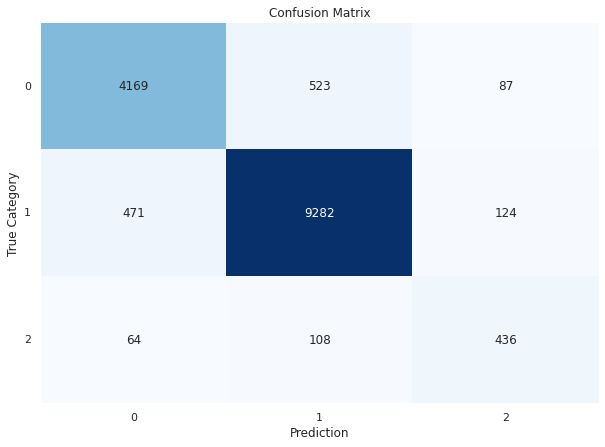

In [177]:
accuracy = accuracy_score(y_test, predicted)
auc = roc_auc_score(y_test, predicted_prob, multi_class='ovr')
print(f"Accuracy: {round(accuracy, 2)}")
print(f"Auc: {round(auc, 2)}")
print(f"Details:\n {classification_report(y_test, predicted)}")

confusion_matrix = confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Prediction', ylabel='True Category', xticklabels=classes, yticklabels=classes, title='Confusion Matrix')

plt.yticks(rotation=0)

In [159]:
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, auc

In [160]:
y_test_array = pd.get_dummies(y_test, drop_first=False).values
y_test_array

array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0]], dtype=uint8)

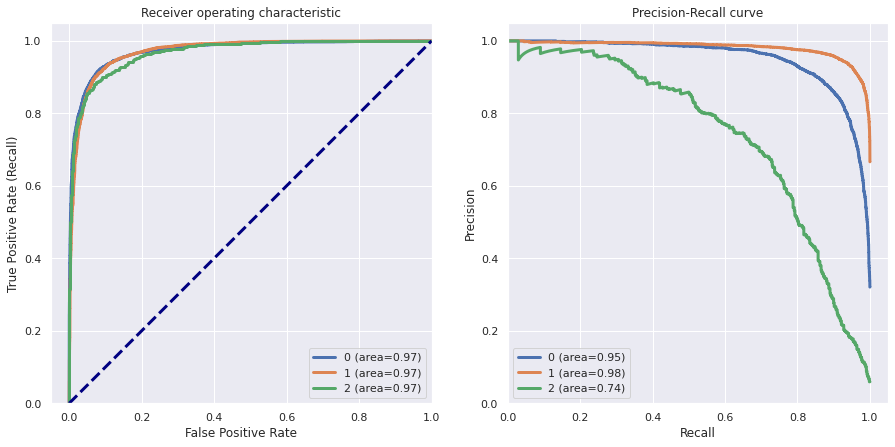

In [162]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i], predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], auc(fpr, tpr)))
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0],
          ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = precision_recall_curve(y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], auc(recall, precision)))
ax[1].set(xlim=[0.0,1.05],
          ylim=[0.0,1.05],
          xlabel='Recall', 
          ylabel="Precision",
          title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()